## Imports

In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = 0
xp.controls.threads = 1
xp.controls.scaling = 0
xp.controls.presolve = 0
xp.controls.feastol = 1.e-7
xp.controls.optimalitytol = 1.e-7
xp.setOutputEnabled(False)

In [5]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

def modify_objective(model, u):
    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
    model.chgrhs(binding_id,[u])
    return(model)

def milp_version(model):
    vars = model.getVariable()
    interger_vars = [i for i in range(len(vars)) if vars[i].name.strip().split("::")[0] in ['NODU', 'NumberBreakingDownDispatchableUnits', 'NumberStartingDispatchableUnits','NumberStoppingDispatchableUnits']]
    for i in interger_vars:
        model.chgcoltype([vars[i]],'I')
    return(model)

## Plot itr 1 et itr 2

In [6]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/BP23_A_saME_EU_Xeq_2036_Thomas_avec pilotage"
output_path = study_path+"/output/20240712-1554eco-exportmps_fast_sirius"

In [7]:
week = 3937//168
hours_week = list(range(168*week+1,168*(week+1)+1))

In [8]:
week

23

In [9]:
m = retrieve_problem(1,week+1,output_path,itr=1)

In [10]:
m.solve()
m.getObjVal()

1588629659.4586039

In [11]:
vars = m.getVariable()

In [12]:
len(vars)

222096

In [13]:
generating_var_cluster = [i for i in range(len(vars)) if "FR_Nuclear_p4" in vars[i].name]

In [14]:
lb_bounds = []
m.getlb(lb_bounds, 0, m.attributes.cols - 1)
ub_bounds = []
m.getub(ub_bounds, 0, m.attributes.cols - 1)

In [15]:
delta = 72
print(168%72)
print(168//72)

24
2


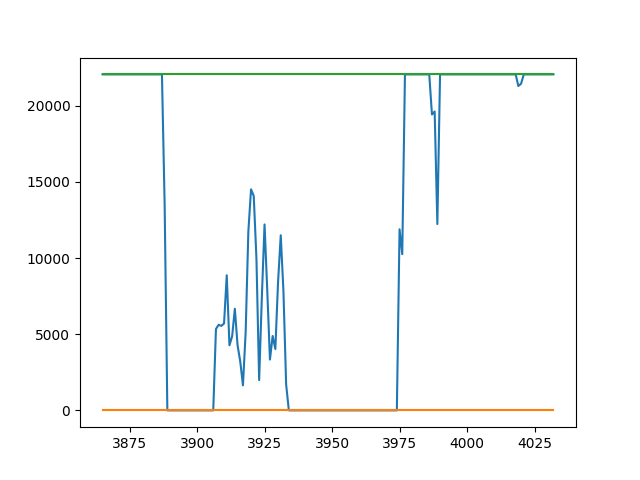

In [16]:
plt.figure()
plt.plot(hours_week,[m.getSolution(vars[i]) for i in generating_var_cluster])
plt.plot(hours_week,[lb_bounds[i] for i in generating_var_cluster])
plt.plot(hours_week,[ub_bounds[i] for i in generating_var_cluster])

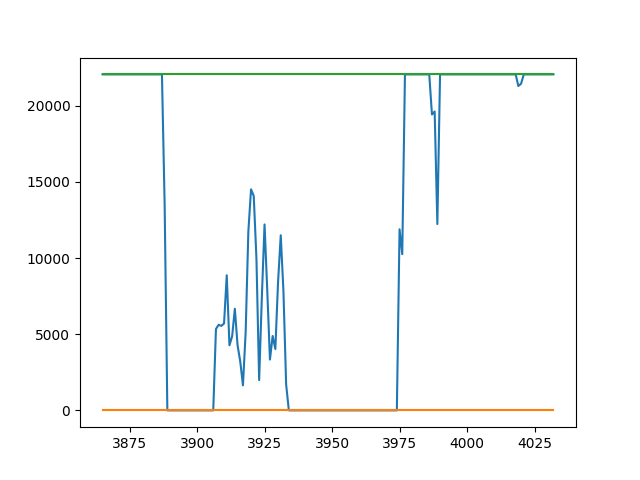

In [17]:
plt.figure()
plt.plot(hours_week,[m.getSolution(vars[i]) for i in generating_var_cluster])
plt.plot(hours_week,[lb_bounds[i] for i in generating_var_cluster])
plt.plot(hours_week,[ub_bounds[i] for i in generating_var_cluster])

## Export pour le POC

In [274]:
output_path_sirius = study_path+"/output/20240712-1554eco-exportmps_fast_sirius"
output_path_xpress = study_path+"/output/20240715-0947eco-xpress_export_mps"

In [275]:
m_sirius_itr1 = retrieve_problem(1,week+1,output_path_sirius,itr=1)
m_xpress_itr1 = retrieve_problem(1,week+1,output_path_xpress,itr=1)
m_xpress_itr2 = retrieve_problem(1,week+1,output_path_xpress,itr=2)

In [276]:
m_xpress_itr1.solve()
m_xpress_itr2.solve()

In [277]:
vars_sirius_itr1 = m_sirius_itr1.getVariable()
names_ref = [v.name for v in vars_sirius_itr1]

In [278]:
def create_dataframe_variables(m,names,name_cluster):
    idx = [i for i in range(len(names)) if name_cluster in names[i]]
    vars = m.getVariable()
    df_vars = pd.DataFrame([vars[i] for i in idx], columns=["var"])
    df_vars["names"] = [names[i] for i in idx]
    df_vars["split"] = df_vars["names"].apply(lambda x:x.strip().split("::"))
    df_vars["name_var"] = df_vars["split"].apply(lambda x:x[0])
    df_vars["antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[0])
    df_vars["name_antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[1].split(">")[0])
    df_vars["subobject"] = df_vars["split"].apply(lambda x:x[2] if len(x)>=4 else "None")
    df_vars["time"] = df_vars["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
# coltype = []
# m.getcoltype(coltype, 0, m.attributes.cols - 1)
# df_vars['coltype'] = coltype
    bounds = []
    m.getlb(bounds, 0, m.attributes.cols - 1)
    df_vars['lb'] = [bounds[i] for i in idx]
    bounds = []
    m.getub(bounds, 0, m.attributes.cols - 1)
    df_vars['ub'] = [bounds[i] for i in idx]
    df_vars = df_vars.assign(sol=[m.getSolution(i) for i in idx])

    return df_vars

In [281]:
name_cluster = "FR_Nuclear_p4"

In [279]:
df_vars_itr1 = create_dataframe_variables(m_xpress_itr1,names_ref,name_cluster)
df_vars_itr2 = create_dataframe_variables(m_xpress_itr2,names_ref,name_cluster)

In [288]:
temp = df_vars_itr1["sol"].values
np.savetxt(f"dev/itr1_fast_cluster.txt",temp)
temp = df_vars_itr2["lb"].values
np.savetxt(f"dev/itr2_fast_cluster.txt",temp)

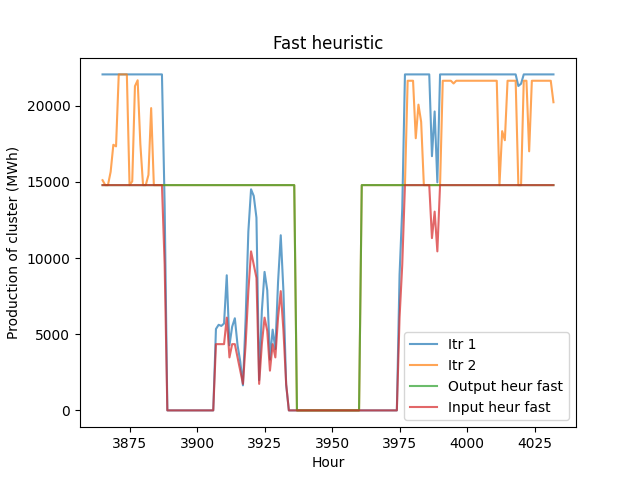

In [292]:
plt.figure()
plt.plot(hours_week,df_vars_itr1["sol"].values,label="Itr 1",alpha=0.7)
plt.plot(hours_week,df_vars_itr2["sol"].values,label="Itr 2",alpha=0.7)
plt.plot(hours_week,df_vars_itr2["lb"].values,label="Output heur fast",alpha=0.7)
plt.plot(hours_week,np.ceil(np.round(df_vars_itr1["sol"].values / 1318.5, 12))*870.21,label="Input heur fast",alpha=0.7)
plt.xlabel("Hour")
plt.ylabel("Production of cluster (MWh)")
plt.title("Fast heuristic")
plt.legend()
plt.show()

## Inspection de toutes les variables

In [18]:
var_fr = [i for i in range(len(vars)) if (("<fr" in vars[i].name) or ("fr>" in vars[i].name)) and ("Cost" not in vars[i].name)]

In [19]:
len(var_fr)

7056

In [20]:
df_vars = pd.DataFrame([vars[i] for i in var_fr], columns=["names"])
df_vars["split"] = df_vars["names"].apply(lambda x:x.name.strip().split("::"))
df_vars["name_var"] = df_vars["split"].apply(lambda x:x[0])
df_vars["antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[0])
df_vars["name_antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[1].split(">")[0])
df_vars["subobject"] = df_vars["split"].apply(lambda x:x[2] if len(x)>=4 else "None")
df_vars["time"] = df_vars["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_vars["time_type"] = df_vars["split"].apply(lambda x:x[-1].split("<")[0])
# coltype = []
# m.getcoltype(coltype, 0, m.attributes.cols - 1)
# df_vars['coltype'] = coltype
# bounds = []
# m.getlb(bounds, 0, m.attributes.cols - 1)
# df_vars['lb'] = bounds
# bounds = []
# m.getub(bounds, 0, m.attributes.cols - 1)
# df_vars['ub'] = bounds
# objcoef = []
# m.getobj(objcoef,0,m.attributes.cols-1)
# df_vars= df_vars.assign(coeff=[objcoef[i] for i in range(m.attributes.cols)])
df_vars = df_vars.assign(sol=[m.getSolution(i) for i in var_fr])
# df_vars = df_vars.assign(obj = lambda x: np.round(df_vars['sol'],6)*np.round(df_vars['coeff'],6))

In [21]:
df_vars["neg"] = df_vars["name_antares_object"].apply(lambda x:True if "fr$$" in x else False)
df_vars["pays"] = df_vars["name_antares_object"].apply(lambda x:x.split("$$")[1] if "fr$$" in x else x.split("$$")[0])
df_vars["name"] = df_vars.apply(lambda x:x.name_var if (x.subobject=="None" and x.antares_object=="area") else (x.subobject if x.antares_object=="area" else x.pays),axis=1)
df_vars["prod"] = df_vars.apply(lambda x:-x.sol if x.neg else x.sol,axis=1)

In [22]:
df_vars

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,sol,neg,pays,name,prod
0,NTCDirect::link<be$$fr>::hour<3864> ...,"[NTCDirect, link<be$$fr>, hour<3864>]",NTCDirect,link,be$$fr,None,3864,hour,-5300.0,False,be,be,-5300.0
1,NTCDirect::link<ch$$fr>::hour<3864> ...,"[NTCDirect, link<ch$$fr>, hour<3864>]",NTCDirect,link,ch$$fr,None,3864,hour,-3700.0,False,ch,ch,-3700.0
2,NTCDirect::link<de$$fr>::hour<3864> ...,"[NTCDirect, link<de$$fr>, hour<3864>]",NTCDirect,link,de$$fr,None,3864,hour,-4800.0,False,de,de,-4800.0
3,NTCDirect::link<es$$fr>::hour<3864> ...,"[NTCDirect, link<es$$fr>, hour<3864>]",NTCDirect,link,es$$fr,None,3864,hour,-5300.0,False,es,es,-5300.0
4,NTCDirect::link<fr$$ie>::hour<3864> ...,"[NTCDirect, link<fr$$ie>, hour<3864>]",NTCDirect,link,fr$$ie,None,3864,hour,-700.0,True,ie,ie,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7051,DispatchableProduction::area<fr>::ThermalClust...,"[DispatchableProduction, area<fr>, ThermalClus...",DispatchableProduction,area,fr,ThermalCluster<FR_VE_inj>,4031,hour,1283.0,False,fr,ThermalCluster<FR_VE_inj>,1283.0
7052,DispatchableProduction::area<fr>::ThermalClust...,"[DispatchableProduction, area<fr>, ThermalClus...",DispatchableProduction,area,fr,ThermalCluster<FR_Waste>,4031,hour,205.8,False,fr,ThermalCluster<FR_Waste>,205.8
7053,PositiveUnsuppliedEnergy::area<fr>::hour<4031>...,"[PositiveUnsuppliedEnergy, area<fr>, hour<4031>]",PositiveUnsuppliedEnergy,area,fr,None,4031,hour,0.0,False,fr,PositiveUnsuppliedEnergy,0.0
7054,NegativeUnsuppliedEnergy::area<fr>::hour<4031>...,"[NegativeUnsuppliedEnergy, area<fr>, hour<4031>]",NegativeUnsuppliedEnergy,area,fr,None,4031,hour,0.0,False,fr,NegativeUnsuppliedEnergy,0.0


In [23]:
df_vars["name_var"].unique()

array(['NTCDirect', 'DispatchableProduction', 'PositiveUnsuppliedEnergy',
       'NegativeUnsuppliedEnergy', 'HydProd'], dtype=object)

In [24]:
df_vars["time_type"].unique()

array(['hour'], dtype=object)

In [25]:
type_gen = df_vars["name"].unique()

In [26]:
type_gen

array(['be', 'ch', 'de', 'es', 'ie', 'itn', 'ukgb', 've_fr_load_journee',
       've_fr_load_total', 've_fr_mobilite_lourde', 'x_closed_pump',
       'x_closed_turb', 'x_open_pump', 'x_open_turb', 'z_batteries',
       'z_batteries_pcomp', 'z_effacement', 'z_p2g_base', 'z_p2g_marg',
       'z_p2g_methanation', 'z_report', 'ThermalCluster<FR_CCGT*new>',
       'ThermalCluster<FR_CCGT*new*DK6>',
       'ThermalCluster<FR_DSR_implicite>',
       'ThermalCluster<FR_DSR_industrie>',
       'ThermalCluster<FR_DSR_tertiaire>', 'ThermalCluster<FR_Gas*CHP>',
       'ThermalCluster<FR_Light*oil>',
       'ThermalCluster<FR_Nuclear_cp0_cp1_cp2>',
       'ThermalCluster<FR_Nuclear_epr>', 'ThermalCluster<FR_Nuclear_n4>',
       'ThermalCluster<FR_Nuclear_p4>',
       'ThermalCluster<FR_Nuclear_peak1>',
       'ThermalCluster<FR_Nuclear_peak2>',
       'ThermalCluster<FR_Nuclear_peak3>', 'ThermalCluster<FR_OCGT*new>',
       'ThermalCluster<FR_OCGT*old>', 'ThermalCluster<FR_VE_inj>',
       'Thermal

In [27]:
output = {}

In [28]:
output["z"] = sum(df_vars.loc[df_vars["name"]==n,"prod"].values for n in type_gen if n in [ 'z_batteries',
       'z_batteries_pcomp', 'z_effacement', 'z_p2g_base', 'z_p2g_marg',
       'z_p2g_methanation', 'z_report'])

In [29]:
output["ve"] = sum(df_vars.loc[df_vars["name"]==n,"prod"].values for n in type_gen if n in ['ve_fr_load_journee',
       've_fr_load_total', 've_fr_mobilite_lourde','ThermalCluster<FR_VE_inj>',])

In [30]:
output["export"] = sum(df_vars.loc[df_vars["name"]==n,"prod"].values for n in type_gen if n in ['be', 'ch', 'de', 'es', 'ie', 'itn', 'ukgb'])

In [31]:
output["x"] = sum(df_vars.loc[df_vars["name"]==n,"prod"].values for n in type_gen if n in ['x_closed_pump',
       'x_closed_turb', 'x_open_pump', 'x_open_turb'])

In [32]:
output["HydProd"] = df_vars.loc[df_vars["name"]=='HydProd',"prod"].values

In [33]:
output["Gas"] = sum(df_vars.loc[df_vars["name"]==n,"prod"].values for n in type_gen if n in ['ThermalCluster<FR_OCGT*new>',
       'ThermalCluster<FR_OCGT*old>','ThermalCluster<FR_CCGT*new>',
       'ThermalCluster<FR_CCGT*new*DK6>','ThermalCluster<FR_Gas*CHP>',
       'ThermalCluster<FR_Light*oil>',])

In [34]:
for n in type_gen:
    if n in [ 
       'ThermalCluster<FR_DSR_implicite>',
       'ThermalCluster<FR_DSR_industrie>',
       'ThermalCluster<FR_DSR_tertiaire>', 
       'ThermalCluster<FR_Nuclear_cp0_cp1_cp2>',
       'ThermalCluster<FR_Nuclear_epr>', 'ThermalCluster<FR_Nuclear_n4>',
       'ThermalCluster<FR_Nuclear_p4>',
       'ThermalCluster<FR_Nuclear_peak1>',
       'ThermalCluster<FR_Nuclear_peak2>',
       'ThermalCluster<FR_Nuclear_peak3>', 'PositiveUnsuppliedEnergy',
       'NegativeUnsuppliedEnergy'] and not(np.all(df_vars.loc[df_vars["name"]==n,"sol"].values == [0]*168)):
        output[n] =df_vars.loc[df_vars["name"]==n,"prod"].values

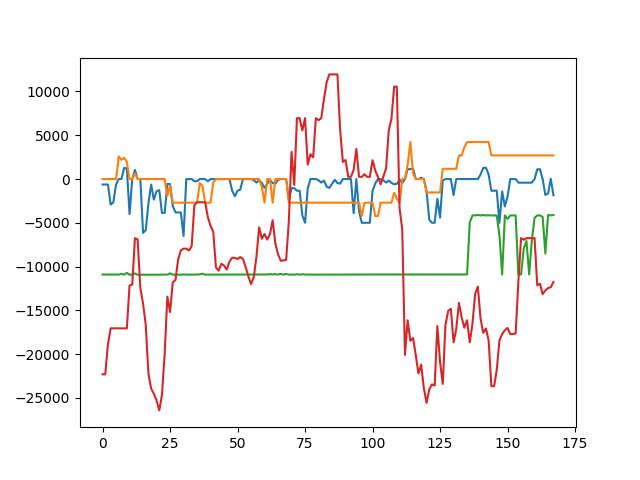

In [35]:
plt.figure()
plt.plot(output["ve"])
plt.plot(output["x"])
plt.plot(output["z"])
plt.plot(output["export"])
plt.show()

In [36]:
len(output)

10

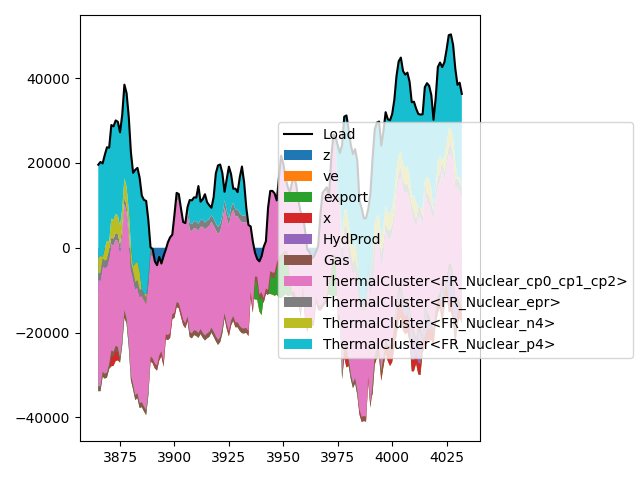

Text(9.444444444444445, 0.5, 'Energy (MWh)')

In [47]:
fig, ax = plt.subplots()
ax.plot(hours_week,load_fr-df_vars.loc[df_vars["name"]=='ThermalCluster<FR_Waste>',"sol"].values,label="Load",color="black")
ax.stackplot(hours_week,output.values(),labels=output.keys())
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.75)
plt.show()
plt.title("Week 24")
plt.xlabel("Hour")
plt.ylabel("Energy (MWh)")

In [52]:
np.savetxt("load.txt",load_fr, fmt='% 4d')

In [38]:
cons = m.getConstraint()

In [39]:
len(cons)

93111

In [40]:
cons_load = [i for i in range(len(cons)) if 'AreaBalance' in cons[i].name and "area<fr>" in cons[i].name]

In [41]:
len(cons_load)

168

In [42]:
rhs = []
m.getrhs(rhs, 0, m.attributes.rows - 1)

In [43]:
load_fr = [-rhs[i] for i in cons_load]

In [44]:
df_cons = pd.DataFrame(cons, columns=["names"])
df_cons["split"] = df_cons["names"].apply(lambda x:x.name.strip().split("::"))
df_cons["name_cons"] = df_cons["split"].apply(lambda x:x[0])
df_cons["antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[0])
df_cons["name_antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[1].split(">")[0] if len(x[1].split("<"))>=2 else "None")
df_cons["time"] = df_cons["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_cons["time_type"] = df_cons["split"].apply(lambda x:x[-1].split("<")[0])
rhs = []
m.getrhs(rhs, 0, m.attributes.rows - 1)
df_cons["rhs"] = rhs

In [45]:
df_cons

,names,split,name_cons,antares_object,name_antares_object,time,time_type,rhs
0,AreaBalance::area<at>::hour<3864> ...,"[AreaBalance, area<at>, hour<3864>]",AreaBalance,area,at,3864,hour,-4.462000e+03
1,FictiveLoads::area<at>::hour<3864> ...,"[FictiveLoads, area<at>, hour<3864>]",FictiveLoads,area,at,3864,hour,6.691000e+03
2,AreaBalance::area<be>::hour<3864> ...,"[AreaBalance, area<be>, hour<3864>]",AreaBalance,area,be,3864,hour,-8.206000e+03
3,FictiveLoads::area<be>::hour<3864> ...,"[FictiveLoads, area<be>, hour<3864>]",FictiveLoads,area,be,3864,hour,6.426000e+03
4,AreaBalance::area<ch>::hour<3864> ...,"[AreaBalance, area<ch>, hour<3864>]",AreaBalance,area,ch,3864,hour,-5.857000e+03
...,...,...,...,...,...,...,...,...
93106,HydroPower::area<w_hydro_open_nom>::week<23> ...,"[HydroPower, area<w_hydro_open_nom>, week<23>]",HydroPower,area,w_hydro_open_nom,23,week,4.266896e+05
93107,HydroPower::area<w_hydro_open_non>::week<23> ...,"[HydroPower, area<w_hydro_open_non>, week<23>]",HydroPower,area,w_hydro_open_non,23,week,9.307200e+05
93108,HydroPower::area<w_hydro_open_nos>::week<23> ...,"[HydroPower, area<w_hydro_open_nos>, week<23>]",HydroPower,area,w_hydro_open_nos,23,week,2.002503e+06
93109,HydroPower::area<w_hydro_open_pl>::week<23> ...,"[HydroPower, area<w_hydro_open_pl>, week<23>]",HydroPower,area,w_hydro_open_pl,23,week,4.027704e+02


In [46]:
df_cons["name_cons"].unique()

array(['AreaBalance', 'FictiveLoads', 'FlowDissociation',
       'Battery_level_AT', 'Battery_level_BE', 'Battery_level_CH',
       'Battery_level_CZ', 'Battery_level_DE', 'Battery_level_DKw',
       'Battery_level_ES', 'Battery_level_IE', 'Battery_level_ITca',
       'Battery_level_ITcn', 'Battery_level_ITcs', 'Battery_level_ITn',
       'Battery_level_ITs', 'Battery_level_ITsar', 'Battery_level_ITsic',
       'Battery_level_LU', 'Battery_level_NL', 'Battery_level_SE1',
       'Battery_level_SE2', 'Battery_level_SE3', 'Battery_level_SE4',
       'Battery_level_UKgb', 'Battery_level_UKni',
       'Battery_pcomp_level_DE', 'Battery_pcomp_level_DKe',
       'Battery_pcomp_level_ES', 'Battery_pcomp_level_NL',
       'Battery_pcomp_level_PL', 'Battery_pcomp_level_PT',
       'P2G_fatalband_at', 'P2G_fatalband_ch', 'P2G_fatalband_cz',
       'P2G_fatalband_dke', 'P2G_fatalband_dkw', 'P2G_fatalband_es',
       'P2G_fatalband_fr', 'P2G_fatalband_itca', 'P2G_fatalband_itcn',
       'P2G_fatalb

In [41]:
m.solve()
print(m.attributes.TIME,m.attributes.SIMPLEXITER,m.getObjVal())

0 264 -556.4687234900006
